## Importacion de librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

## Funciones

In [2]:
def diag_residuos (ytrain, Xtrain_std,model):

    # Diagnóstico errores (residuos) de las predicciones de entrenamiento
    # ==============================================================================
    prediccion_train = model.predict(Xtrain_std)
    residuos_train   = prediccion_train - ytrain
    # Gráficos
    # ==============================================================================
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

    axes[0, 0].scatter(ytrain, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([ytrain.min(), ytrain.max()], [ytrain.min(), ytrain.max()],'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(ytrain))), residuos_train, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot( data = residuos_train, stat = "density", kde = True, line_kws= {'linewidth': 1}, color = "firebrick", alpha   = 0.3, ax = axes[1, 0])

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot( residuos_train, fit = True, line  = 'q', ax = axes[1, 1], color = 'firebrick', alpha = 0.4, lw = 2 )

    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(prediccion_train, residuos_train, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    # Se eliminan los axes vacíos
    fig.delaxes(axes[2,1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

## Carga del CSV

In [3]:
# Carga de CSV
data_location = "../TP_Limpieza/Data/data_clean.csv"
data = pd.read_csv(data_location, index_col=0)

### Seleccion de datos a modelar del CSV

**Se selecciona modelar las observaciones correspondientes a Capital Federal ya que la granularidad de estos datos es mas fina, y la cantidad de instancias es suficiente para tener valor predictivo**

In [4]:
# Seleccion de datos a modelar
data = data [data.state_name == "Capital Federal"]
data.shape

(23482, 17)

## Matriz features y target

### Analisis de correlacion de variables predictivas

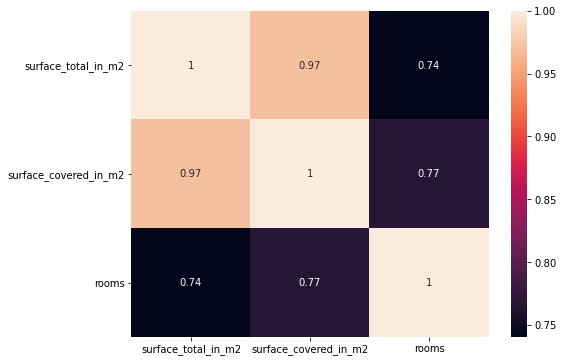

In [5]:
# Grafico de correlacion
feature_columns = ["surface_total_in_m2", "surface_covered_in_m2" , "rooms"]
data_corr = data[feature_columns]
corr_feature = data_corr.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_feature, annot=True)
plt.show()

#### Variables de interaccion

In [6]:
# Interaccion de variables
data["surface_covered_in_m2*rooms"] = data.surface_covered_in_m2 * data.rooms
data["surface_total_in_m2*rooms"] = data.surface_total_in_m2 * data.rooms
data["surface_covered_in_m2*surface_total_in_m2"] = data.surface_covered_in_m2 * data.surface_total_in_m2    

### Tratamiento de variables predictivas categoricas

**Para introducir las variables categoricas en el modelo de regresion lineal, se utilizan variables dummies**

In [7]:
# Transformacion de variables categoricas en variables dummies
dummies_property_type = pd.get_dummies(data['property_type'])
dummies_state_name = pd.get_dummies(data['state_name'])
dummies_city_name = pd.get_dummies(data['city_name'])
dummies_neighborhood_name = pd.get_dummies(data['neighborhood_name'])

In [8]:
# Concatenacion de los dataframes dummies a data
data = pd.concat([data, dummies_property_type,dummies_city_name, dummies_neighborhood_name],axis=1)

In [9]:
# Dropeado de columnas innecesarias y de instancias con algun nulo
data = data.drop(columns = ['operation',"country_name","geonames_id","lat","lon","description","title","rooms_per_m2" , "price_usd_per_m2","property_type",
                          "state_name" , "city_name" , "neighborhood_name" ])
data.shape

(23482, 72)

### Configuracion de set de entrenamiento y testeo

**Se setean los parametros de seleccion de set de entrenamiento y testeo de forma de entrenar y testear los modelos con los mismos datos de forma de poder compararlos**

In [10]:
# Seleccion de matriz de features de data y target
X = data.drop(["price_aprox_usd"], axis=1)

# Seleccion de vector de target
y = data.price_aprox_usd
print("Variables predictoras= \n", X.columns)

Variables predictoras= 
 Index(['surface_total_in_m2', 'surface_covered_in_m2', 'rooms',
       'surface_covered_in_m2*rooms', 'surface_total_in_m2*rooms',
       'surface_covered_in_m2*surface_total_in_m2', 'PH', 'apartment', 'house',
       'store', 'Abasto', 'Agronomía', 'Almagro', 'Balvanera', 'Barracas',
       'Barrio Norte', 'Belgrano', 'Boca', 'Boedo', 'Caballito', 'Catalinas',
       'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales',
       'Congreso', 'Constitución', 'Flores', 'Floresta', 'Las Cañitas',
       'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro', 'Nuñez', 'Once',
       'Palermo', 'Parque Avellaneda', 'Parque Centenario', 'Parque Chacabuco',
       'Parque Chas', 'Parque Patricios', 'Paternal', 'Pompeya',
       'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra', 'San Cristobal',
       'San Nicolás', 'San Telmo', 'Tribunales', 'Velez Sarsfield',
       'Versalles', 'Villa Crespo', 'Villa Devoto', 'Villa General Mitre',
       'Villa Lugano', 'Villa 

### Split de train y test

In [11]:
# Split en train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state=155)

# Transformacion de variables dummies de train y test en array numpy
data_dummies_train = Xtrain.iloc[:, 6:]
data_dummies_test = Xtest.iloc[:, 6:]

arr_data_dummies_train = data_dummies_train.to_numpy()
arr_data_dummies_test = data_dummies_test.to_numpy()

# Se eliminan las variables dummies de las features a normalizar
Xtrain = Xtrain.iloc[:,:6]
Xtest = Xtest.iloc[:,:6]

print(Xtrain.columns)
print(Xtest.columns)
print(data_dummies_train.columns)
print(data_dummies_test.columns)

Index(['surface_total_in_m2', 'surface_covered_in_m2', 'rooms',
       'surface_covered_in_m2*rooms', 'surface_total_in_m2*rooms',
       'surface_covered_in_m2*surface_total_in_m2'],
      dtype='object')
Index(['surface_total_in_m2', 'surface_covered_in_m2', 'rooms',
       'surface_covered_in_m2*rooms', 'surface_total_in_m2*rooms',
       'surface_covered_in_m2*surface_total_in_m2'],
      dtype='object')
Index(['PH', 'apartment', 'house', 'store', 'Abasto', 'Agronomía', 'Almagro',
       'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
       'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita',
       'Coghlan', 'Colegiales', 'Congreso', 'Constitución', 'Flores',
       'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat',
       'Monte Castro', 'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda',
       'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
       'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'Recoleta',
       '

### Split de train y test para modelo OLS

In [12]:
# Seteado de data para OLS (se utiliza otro split en train y test en OLS ya que necesita el agregado de una constante)
X_sm = sm.add_constant(X)
Xtrainsm, Xtestsm, ytrainsm, ytestsm = train_test_split(X_sm, y, test_size = 0.3, random_state=155)

# Transformacion de variables dummies de train y test en array numpy
data_dummies_trainsm = Xtrainsm.iloc[:, 7:]
data_dummies_testsm = Xtestsm.iloc[:, 7:]

arr_data_dummies_trainsm = data_dummies_trainsm.to_numpy()
arr_data_dummies_testsm = data_dummies_testsm.to_numpy()

# Se eliminan las variables dummies de las features a normalizar
Xtrainsm = Xtrainsm.iloc[:,:7]
Xtestsm = Xtestsm.iloc[:,:7]

print(Xtrainsm.columns)
print(Xtestsm.columns)
print(data_dummies_trainsm.columns)
print(data_dummies_testsm.columns)

Index(['const', 'surface_total_in_m2', 'surface_covered_in_m2', 'rooms',
       'surface_covered_in_m2*rooms', 'surface_total_in_m2*rooms',
       'surface_covered_in_m2*surface_total_in_m2'],
      dtype='object')
Index(['const', 'surface_total_in_m2', 'surface_covered_in_m2', 'rooms',
       'surface_covered_in_m2*rooms', 'surface_total_in_m2*rooms',
       'surface_covered_in_m2*surface_total_in_m2'],
      dtype='object')
Index(['PH', 'apartment', 'house', 'store', 'Abasto', 'Agronomía', 'Almagro',
       'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca', 'Boedo',
       'Caballito', 'Catalinas', 'Centro / Microcentro', 'Chacarita',
       'Coghlan', 'Colegiales', 'Congreso', 'Constitución', 'Flores',
       'Floresta', 'Las Cañitas', 'Liniers', 'Mataderos', 'Monserrat',
       'Monte Castro', 'Nuñez', 'Once', 'Palermo', 'Parque Avellaneda',
       'Parque Centenario', 'Parque Chacabuco', 'Parque Chas',
       'Parque Patricios', 'Paternal', 'Pompeya', 'Puerto Madero', 'R

# Regresion lineal multiple OLS

In [14]:
# Normalizacion por standar scaler de features de train y test
scaler = StandardScaler()

Xtrain_stdsm = scaler.fit_transform(Xtrainsm)
Xtest_stdsm = scaler.transform(Xtestsm)

# Concatenacion de variables dummies
Xtrain_stdsm = np.concatenate((Xtrain_stdsm, arr_data_dummies_trainsm), axis=1)
Xtest_stdsm = np.concatenate((Xtest_stdsm, arr_data_dummies_testsm), axis=1)

# Fiteado del modelo
model_OLS = sm.OLS(ytrain, Xtrain_stdsm).fit()

print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     775.0
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        20:04:42   Log-Likelihood:            -2.0043e+05
No. Observations:               16437   AIC:                         4.010e+05
Df Residuals:                   16366   BIC:                         4.016e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.081e-13   1.34e-13     -4.547      0.0

### Diagnostico de residuos OLS

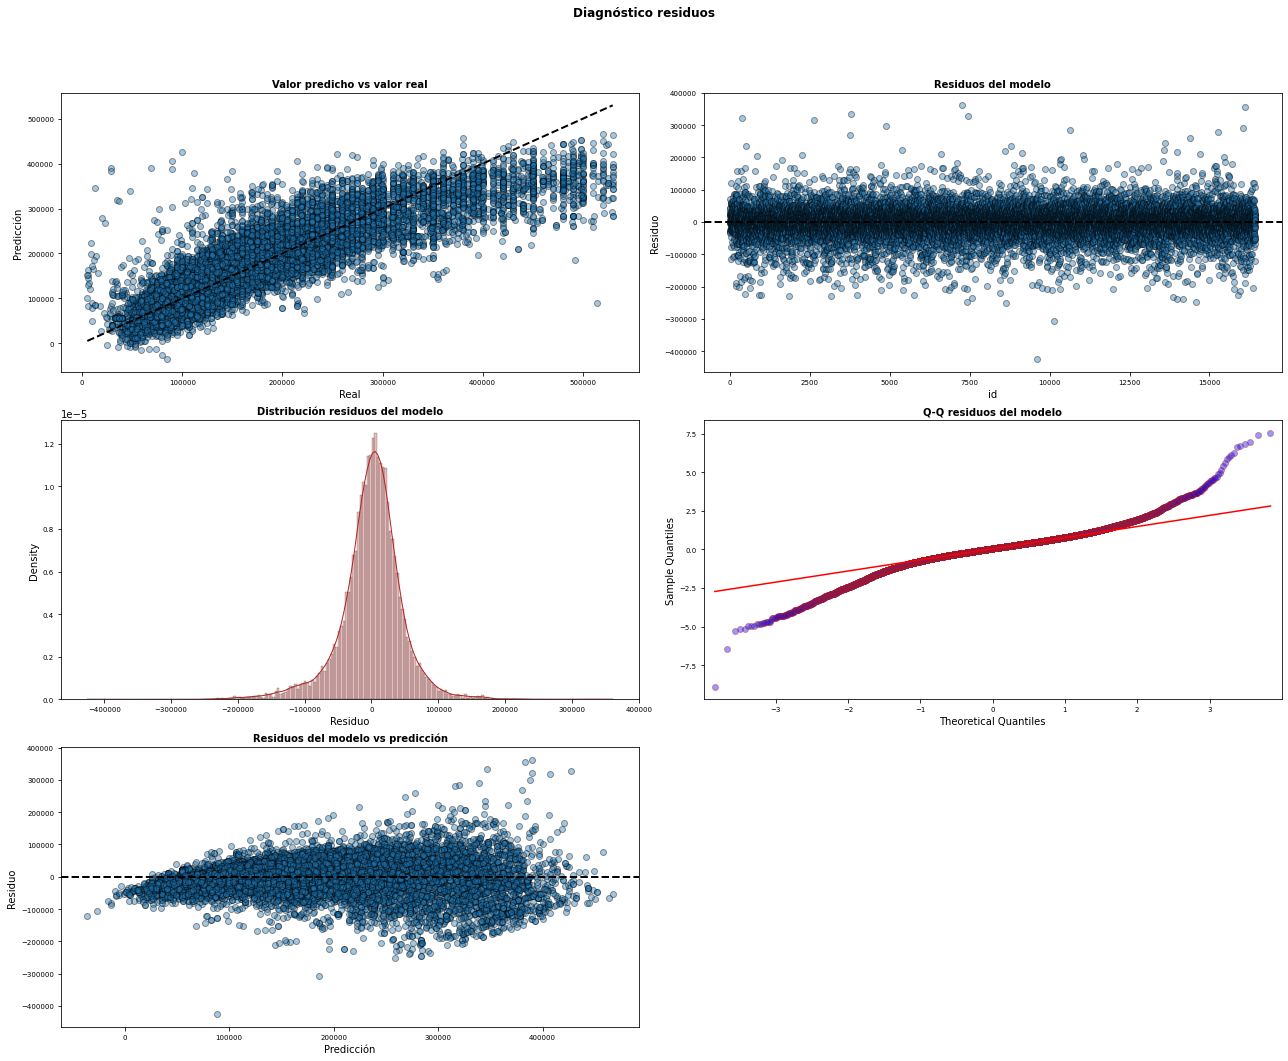

In [14]:
diag_residuos(ytrain,Xtrain_stdsm,model_OLS)

# Regresion lineal multiple

In [15]:
# Normalizacion por standar scaler de features de train y test
scaler = StandardScaler()

Xtrain_std = scaler.fit_transform(Xtrain) 
Xtest_std = scaler.transform(Xtest)

# Concatenacion de variables dummies a set de train y test
Xtrain_std = np.concatenate((Xtrain_std, arr_data_dummies_train), axis=1)
Xtest_std = np.concatenate((Xtest_std, arr_data_dummies_test), axis=1)

In [16]:
# Fiteado del modelo
model_LR = LinearRegression()
model_LR.fit(Xtrain_std , ytrain)

# Resultado de R2 de train y test
print(" R2 train LinearRegression= " , model_LR.score(Xtrain_std, ytrain))
print(" R2 test LinearRegression= " , model_LR.score(Xtest_std, ytest))   

 R2 train LinearRegression=  0.7682363219595185
 R2 test LinearRegression=  0.7749509893959248


In [17]:
# Parametros e hiperparametros del modelo
print("Intercept LinearRegression = ", model_LR.intercept_)
print("coefficients LinearRegression = \n", model_LR.coef_)

Intercept LinearRegression =  -4310705943248636.0
coefficients LinearRegression = 
 [ 2.62115456e+04  1.16227725e+05  5.39248563e+02 -3.56460551e+04
  4.96693539e+04 -7.81345687e+04  4.31070594e+15  4.31070594e+15
  4.31070594e+15  4.31070594e+15 -6.29048898e+03 -8.63795947e+03
 -1.66875000e+03 -2.91786250e+04 -1.28501641e+04  4.15419375e+04
  5.10780000e+04 -4.53185938e+04 -1.21183125e+04  1.87457500e+04
  8.77850107e+04 -3.80156250e+03  3.01798438e+03  2.67397344e+04
  2.78965625e+04 -3.13368750e+04 -3.23733281e+04 -1.20393750e+04
 -2.39789688e+04  6.86312031e+04 -2.00650000e+04 -4.01631250e+04
 -1.21718125e+04 -1.68494805e+04  4.52256250e+04 -2.41369922e+04
  5.03850000e+04 -5.37264941e+04  6.23747852e+03 -2.23661602e+04
  5.20813281e+03 -2.20455312e+04 -1.33287812e+04 -8.84870342e+04
  1.43953359e+05  6.08873438e+04  2.58914688e+04  2.33805000e+04
 -2.48176875e+04 -1.28007812e+04  5.53362500e+03 -2.05014883e+04
 -1.21337656e+04 -2.23634297e+04  1.52500000e+04  1.65004922e+04
  7.81

### Diagnostico de residuos Linear Regression

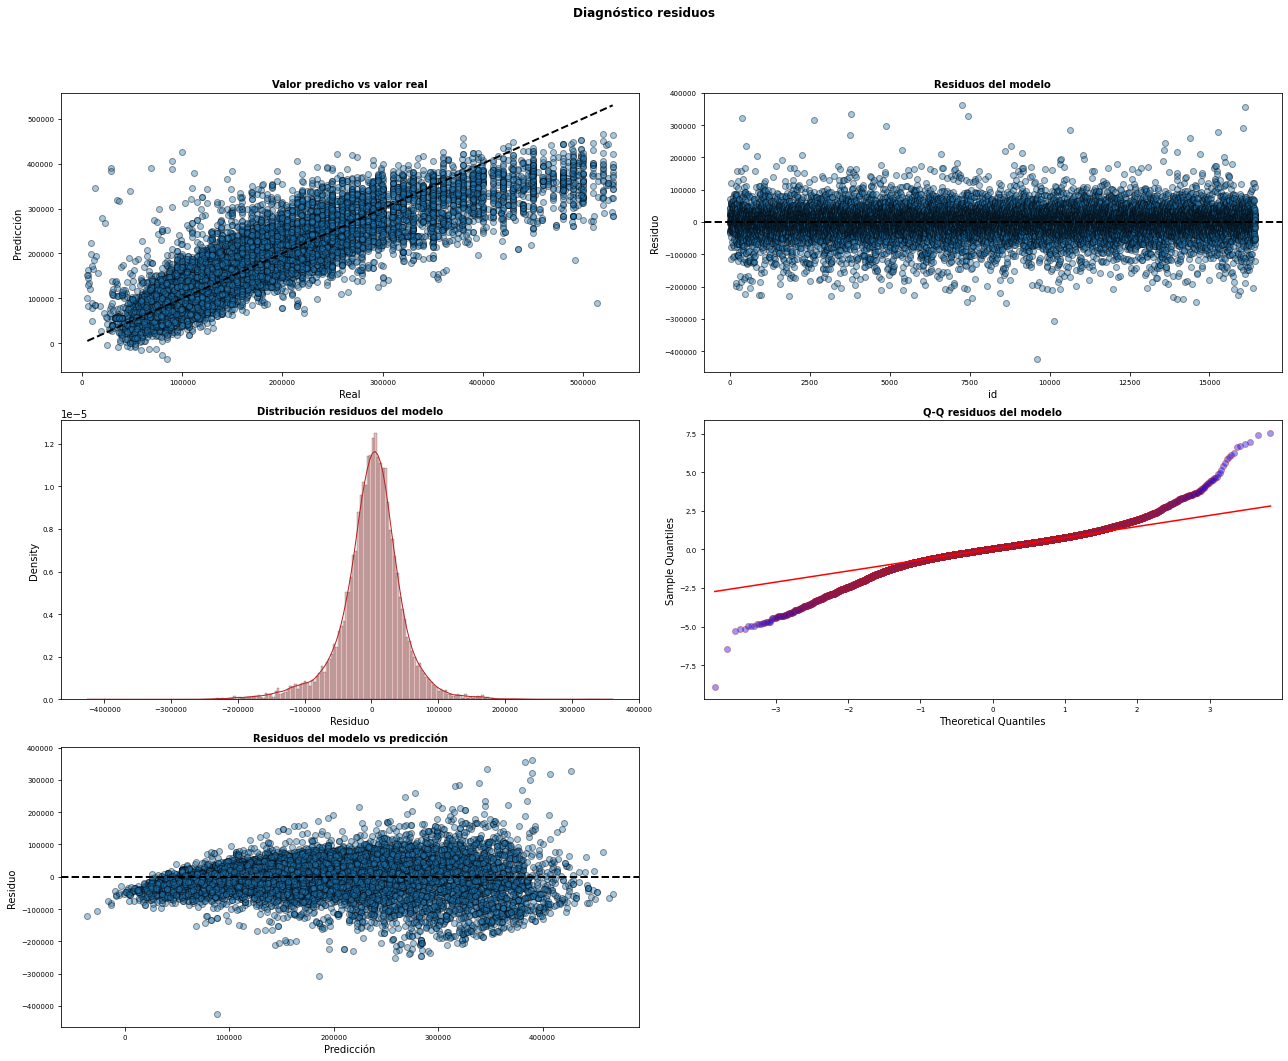

In [18]:
diag_residuos(ytrain,Xtrain_std,model_LR)

# Regularizacion Ridge

In [19]:
# Normalizacion por standar scaler de features de train y test
scaler = StandardScaler()

Xtrain_std = scaler.fit_transform(Xtrain) 
Xtest_std = scaler.transform(Xtest)

# Concatenacion de variables dummies a set de train y test
Xtrain_std = np.concatenate((Xtrain_std, arr_data_dummies_train), axis=1)
Xtest_std = np.concatenate((Xtest_std, arr_data_dummies_test), axis=1)

In [20]:
# Obtencion de hiperparametro alpha con cross validation
model_ridge_cv = linear_model.RidgeCV(alphas = [0.1, 0.7, 0.8, 0.9, 5, 20, 100]  , cv=3) 
model_fit_ridge_cv = model_ridge_cv.fit(Xtrain_std, ytrain)

print("Best alpha RidgeCV = ",model_fit_ridge_cv.alpha_)
print("R2 train RidgeCV = " ,model_fit_ridge_cv.best_score_)

Best alpha RidgeCV =  0.8
R2 train RidgeCV =  0.7645758515723662


In [21]:
# Fiteado del modelo con el mejor hiperparametro alpha
best_alpha_ridge = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha_ridge)
model_fit_ridge = model_ridge.fit(Xtrain_std, ytrain)

# Resultado de R2 de train y test
print(" R2 train Ridge= " , model_fit_ridge.score(Xtrain_std, ytrain))
print(" R2 test Ridge= " , model_fit_ridge.score(Xtest_std, ytest)) 

 R2 train Ridge=  0.768208995941509
 R2 test Ridge=  0.7749526152615094


In [22]:
# Parametros e hiperparametros del modelo
print("Alpha Ridge = ",best_alpha_ridge)
print("Intercept Ridge = ",model_fit_ridge.intercept_)
print("coefficients Ridge = \n",model_fit_ridge.coef_)

Alpha Ridge =  0.8
Intercept Ridge =  142872.65218443525
coefficients Ridge = 
 [ 27998.56701282 114346.31366555    605.51449359 -33139.23941739
  47019.83850087 -77928.59706625 -14749.44700788  14950.69680356
 -14539.3306024   14338.0808068   -6006.34982959  -8115.80445223
  -1446.54948667 -28909.52467826 -12579.21354963  41703.83746343
  51254.25054889 -44849.78857859 -11877.97473751  18947.38089922
  48941.27218181  -3561.24062705   3216.0497968   26819.13517074
  28021.99115546 -30992.16482418 -31964.68046437 -11809.23488584
 -23661.58788461  68037.0361677  -19757.98050493 -39806.36953873
 -11958.2525838  -16322.71755934  45358.48895453 -23757.44868051
  50587.40292394 -52028.59610422   6351.49133496 -21860.9846743
   5297.49709122 -21724.93403489 -12989.82433483 -85514.99237356
 138320.55229939  61037.34408633  25922.80554744  23504.80687259
 -24507.95655585 -12490.13027217   5715.26129991 -20008.10855662
 -11470.03917354 -21515.87134641  15445.73105332  16669.87449824
    960.320

### Analisis de residuos Ridge

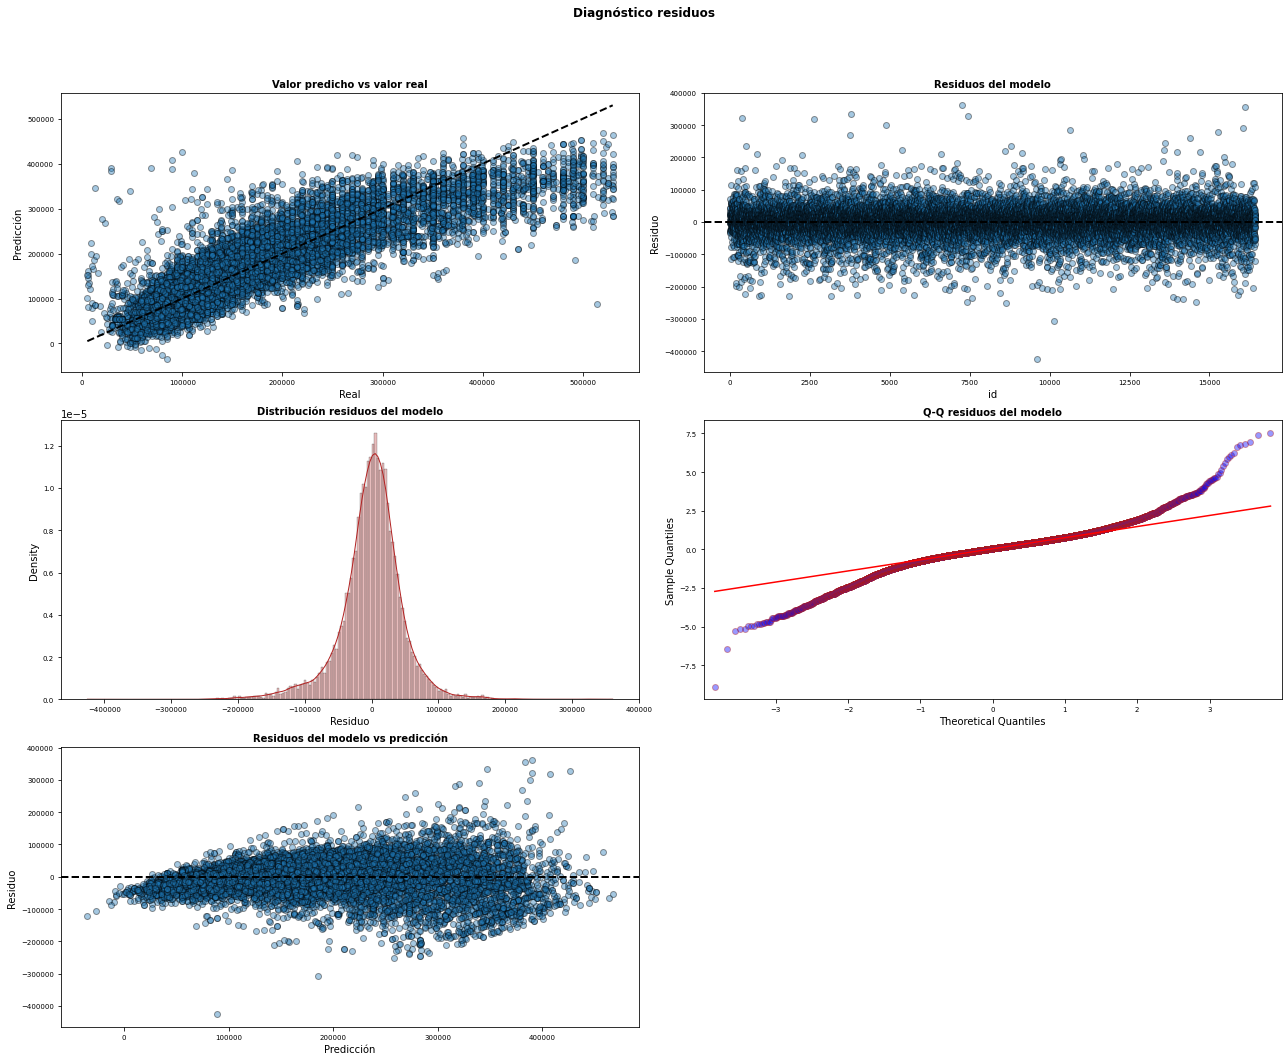

In [23]:
diag_residuos(ytrain,Xtrain_std,model_fit_ridge)

# Regularizacion Lasso 

In [24]:
# Normalizacion por standar scaler de features de train y test
scaler = StandardScaler()

Xtrain_std = scaler.fit_transform(Xtrain) 
Xtest_std = scaler.transform(Xtest)

# Concatenacion de variables dummies a set de train y test
Xtrain_std = np.concatenate((Xtrain_std, arr_data_dummies_train), axis=1)
Xtest_std = np.concatenate((Xtest_std, arr_data_dummies_test), axis=1)

In [25]:
# Obtencion de hiperparametro alpha con cross validation
model_lasso_cv = linear_model.LassoCV(alphas= [0.1 , 1 , 5, 6, 7, 8], cv=3 , max_iter = 1e4)
model_fit_lasso_cv = model_lasso_cv.fit(Xtrain_std, ytrain)

print("Best alpha LassoCV = ", model_fit_lasso_cv.alpha_)
print("R2 train LassoCV = " , model_fit_lasso_cv.score(Xtrain_std, ytrain))

Best alpha LassoCV =  7.0
R2 train LassoCV =  0.7680634308778481


In [26]:
# Fiteado del modelo con el mejor hiperparametro alpha
best_alpha_lasso = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = best_alpha_lasso,  max_iter = 1e4)
model_fit_lasso = model_lasso.fit(Xtrain_std, ytrain)

# Resultado de R2 de train y test
print(" R2 train Lasso = " , model_fit_lasso.score(Xtrain_std, ytrain))
print(" R2 test Lasso = " , model_fit_lasso.score(Xtest_std, ytest)) 

 R2 train Lasso =  0.7680634308778481
 R2 test Lasso =  0.7749131961731444


In [27]:
# Parametros e hiperparametros del modelo
print("Alpha Lasso = ", best_alpha_lasso)
print("Intercept Lasso = ", model_fit_lasso.intercept_)
print("coefficients Lasso = \n", model_fit_lasso.coef_)

Alpha Lasso =  7.0
Intercept Lasso =  146631.7921132065
coefficients Lasso = 
 [ 2.97384144e+04  1.12552256e+05  5.98876632e+02 -3.06019839e+04
  4.43933163e+04 -7.77710801e+04 -2.03153731e+04  9.49977993e+03
 -1.98387050e+04  8.60127729e+03 -2.60896988e+03 -1.45238684e+03
  8.21191671e+01 -2.69759772e+04 -1.04621894e+04  4.32782337e+04
  5.28939151e+04 -4.25723760e+04 -9.82435192e+03  2.05711343e+04
  0.00000000e+00 -8.90971776e+02  4.07160997e+03  2.79332926e+04
  2.93306995e+04 -2.88151047e+04 -2.96056718e+04 -9.98153199e+03
 -2.15972631e+04  6.88269432e+04 -1.76339110e+04 -3.77861355e+04
 -9.96261291e+03 -1.24594966e+04  4.68719261e+04 -2.11779024e+04
  5.22532764e+04 -4.77592136e+04  5.73805286e+03 -1.88024074e+04
  2.89134266e+03 -1.94101164e+04 -1.02743877e+04 -8.19101704e+04
  1.39780584e+05  6.26516362e+04  2.67625609e+04  2.48648528e+04
 -2.23664173e+04 -9.79680045e+03  7.23844943e+03 -1.64501463e+04
 -4.75505696e+03 -1.67069027e+04  1.70069727e+04  1.79159262e+04
  0.0000000

### Diagnostico de residuos Lasso

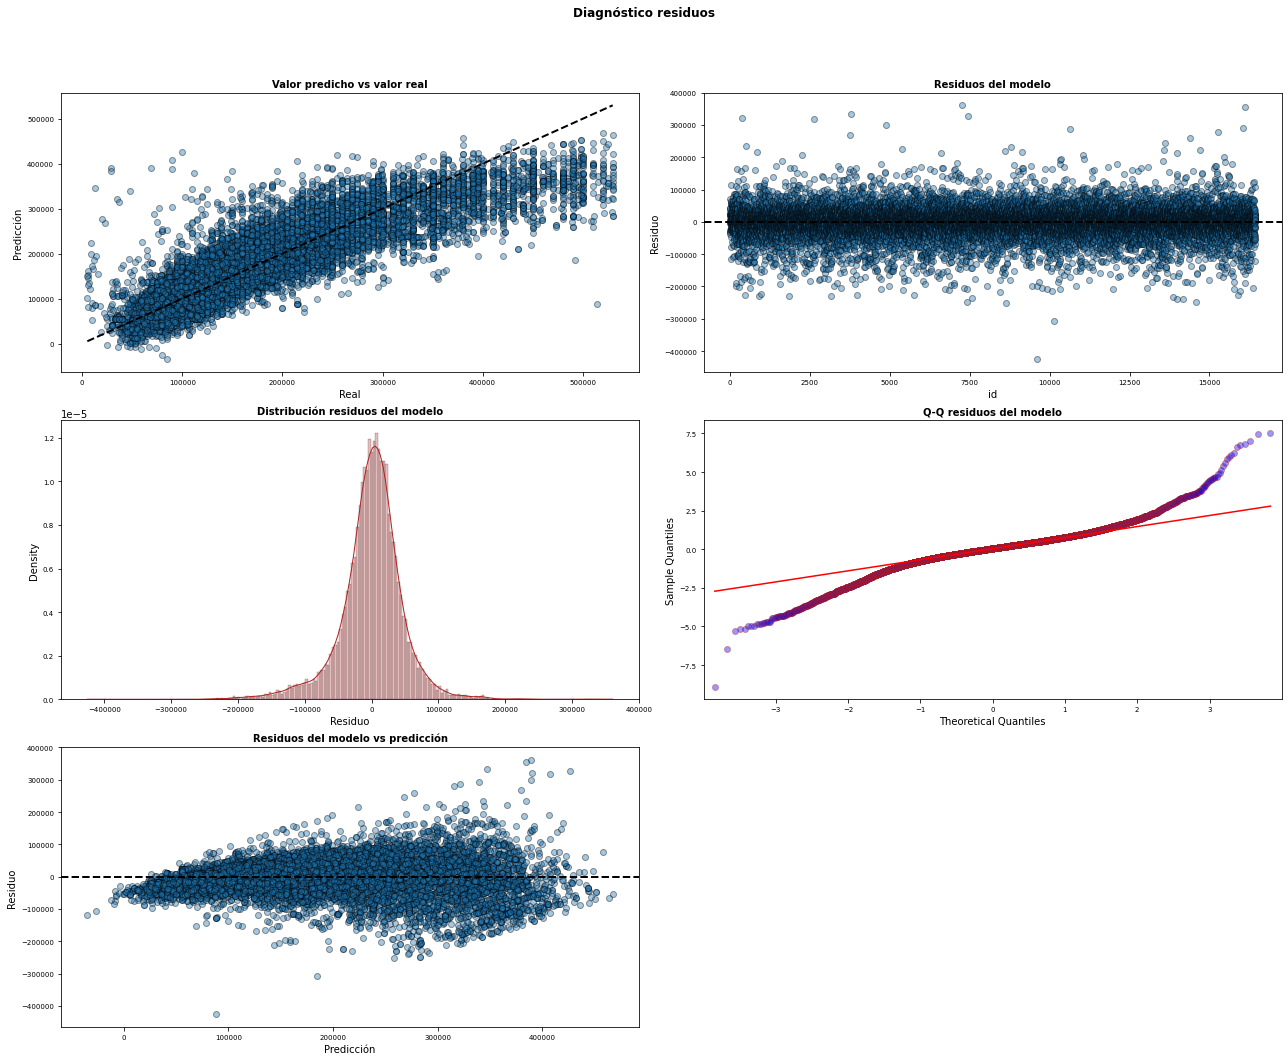

In [28]:
diag_residuos(ytrain,Xtrain_std,model_fit_lasso)

# Regularizacion ElasticNet

In [29]:
# Normalizacion por standar scaler de features de train y test
scaler = StandardScaler()

Xtrain_std = scaler.fit_transform(Xtrain) 
Xtest_std = scaler.transform(Xtest)

# Concatenacion de variables dummies a set de train y test
Xtrain_std = np.concatenate((Xtrain_std, arr_data_dummies_train), axis=1)
Xtest_std = np.concatenate((Xtest_std, arr_data_dummies_test), axis=1)

In [30]:
# Obtencion de hiperparametros alpha y l1_ratio con cross validation
model_elasticnet_cv = linear_model.ElasticNetCV(l1_ratio= [0.1 , 0.3 , 0.5 , 0.7 , 0.9, 1] , alphas= [0.1 , 1 , 5, 6, 7, 8], cv=3, max_iter = 1e4) 
model_fit_elasticnet_cv = model_elasticnet_cv.fit(Xtrain_std, ytrain)

print("Best l1_ratio ElasticNetCV = ", model_fit_elasticnet_cv.l1_ratio_)
print("Best alpha ElasticNetCV = ",model_fit_elasticnet_cv.alpha_)
print("R2 train ElasticNetCV = " , model_fit_elasticnet_cv.score(Xtrain_std, ytrain))

Best l1_ratio ElasticNetCV =  1.0
Best alpha ElasticNetCV =  7.0
R2 train ElasticNetCV =  0.7680634308778481


In [31]:
# Fiteado del modelo con los mejores hiperparametros alpha y l1_ratio
best_l1_ratio_elasticnet = model_fit_elasticnet_cv.l1_ratio_
best_alpha_elasticnet = model_fit_elasticnet_cv.alpha_
model_elasticnet = linear_model.ElasticNet(l1_ratio = best_l1_ratio_elasticnet , alpha = best_alpha_elasticnet, max_iter = 1e4)
model_fit_elasticnet = model_elasticnet.fit(Xtrain_std, ytrain)

# Resultado de R2 de train y test
print(" R2 train ElasticNet = " , model_fit_elasticnet.score(Xtrain_std, ytrain))
print(" R2 test ElasticNet = " , model_fit_elasticnet.score(Xtest_std, ytest)) 

 R2 train ElasticNet =  0.7680634308778481
 R2 test ElasticNet =  0.7749131961731444


In [32]:
# Parametros e hiperparametros del modelo
print("l1_ratio ElasticNet = ", best_l1_ratio_elasticnet)
print("Alpha ElasticNet = ", best_alpha_elasticnet)
print("Intercept ElasticNet = ",model_fit_elasticnet.intercept_)
print("coefficients ElasticNet = \n", model_fit_elasticnet.coef_)

l1_ratio ElasticNet =  1.0
Alpha ElasticNet =  7.0
Intercept ElasticNet =  146631.7921132065
coefficients ElasticNet = 
 [ 2.97384144e+04  1.12552256e+05  5.98876632e+02 -3.06019839e+04
  4.43933163e+04 -7.77710801e+04 -2.03153731e+04  9.49977993e+03
 -1.98387050e+04  8.60127729e+03 -2.60896988e+03 -1.45238684e+03
  8.21191671e+01 -2.69759772e+04 -1.04621894e+04  4.32782337e+04
  5.28939151e+04 -4.25723760e+04 -9.82435192e+03  2.05711343e+04
  0.00000000e+00 -8.90971776e+02  4.07160997e+03  2.79332926e+04
  2.93306995e+04 -2.88151047e+04 -2.96056718e+04 -9.98153199e+03
 -2.15972631e+04  6.88269432e+04 -1.76339110e+04 -3.77861355e+04
 -9.96261291e+03 -1.24594966e+04  4.68719261e+04 -2.11779024e+04
  5.22532764e+04 -4.77592136e+04  5.73805286e+03 -1.88024074e+04
  2.89134266e+03 -1.94101164e+04 -1.02743877e+04 -8.19101704e+04
  1.39780584e+05  6.26516362e+04  2.67625609e+04  2.48648528e+04
 -2.23664173e+04 -9.79680045e+03  7.23844943e+03 -1.64501463e+04
 -4.75505696e+03 -1.67069027e+04  

### Diagnostico de residuos ElasticNet

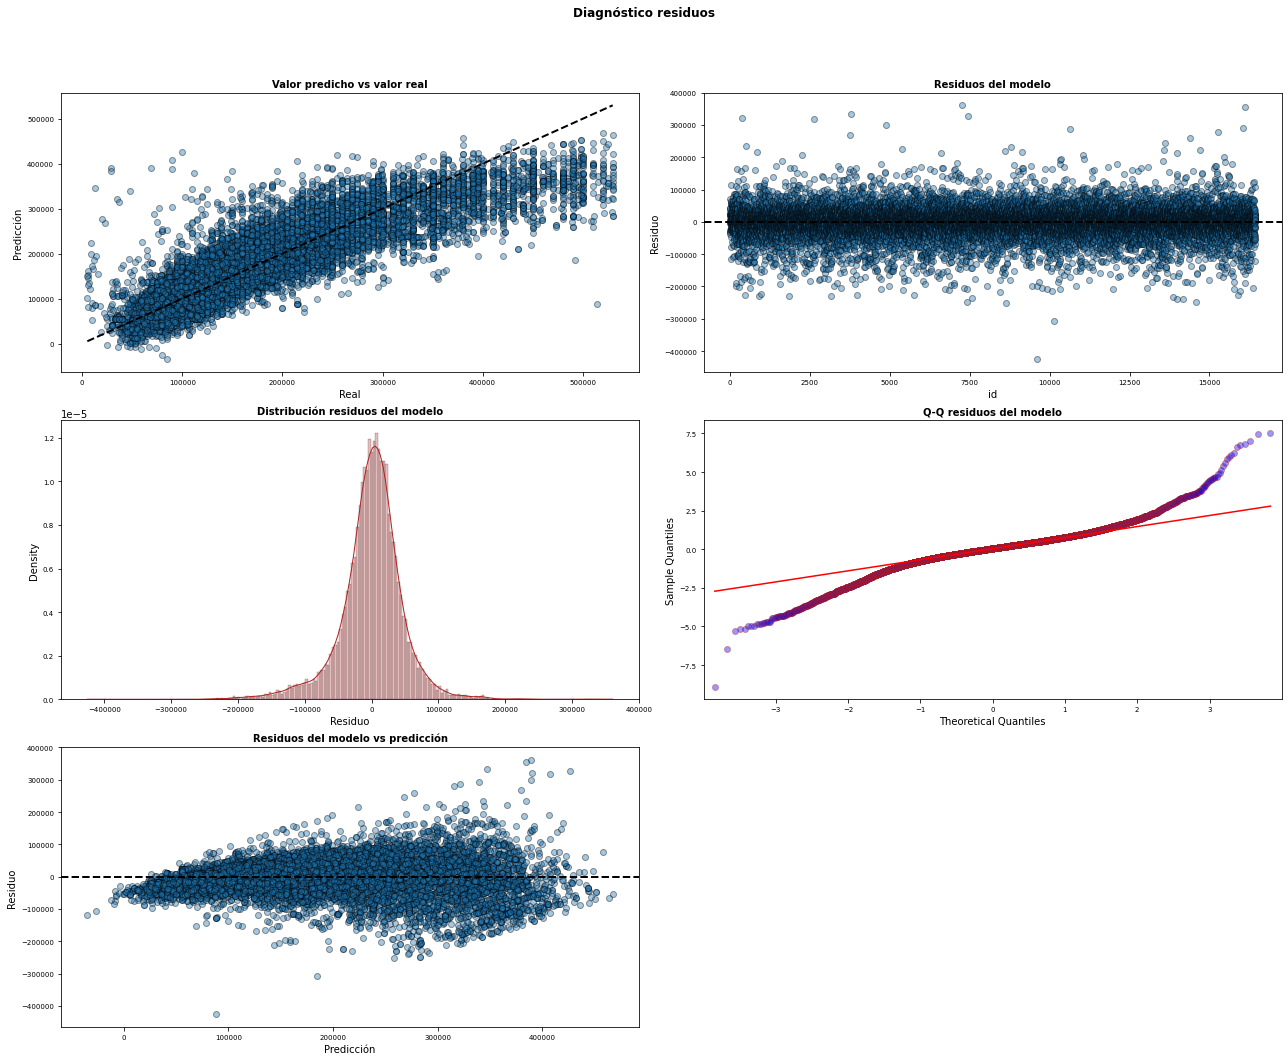

In [33]:
diag_residuos(ytrain,Xtrain_std,model_fit_elasticnet)